In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [2]:
makam_usul_counts_path = "../data/makam_usul_counts.csv"
df = pd.read_csv(makam_usul_counts_path, index_col=0)

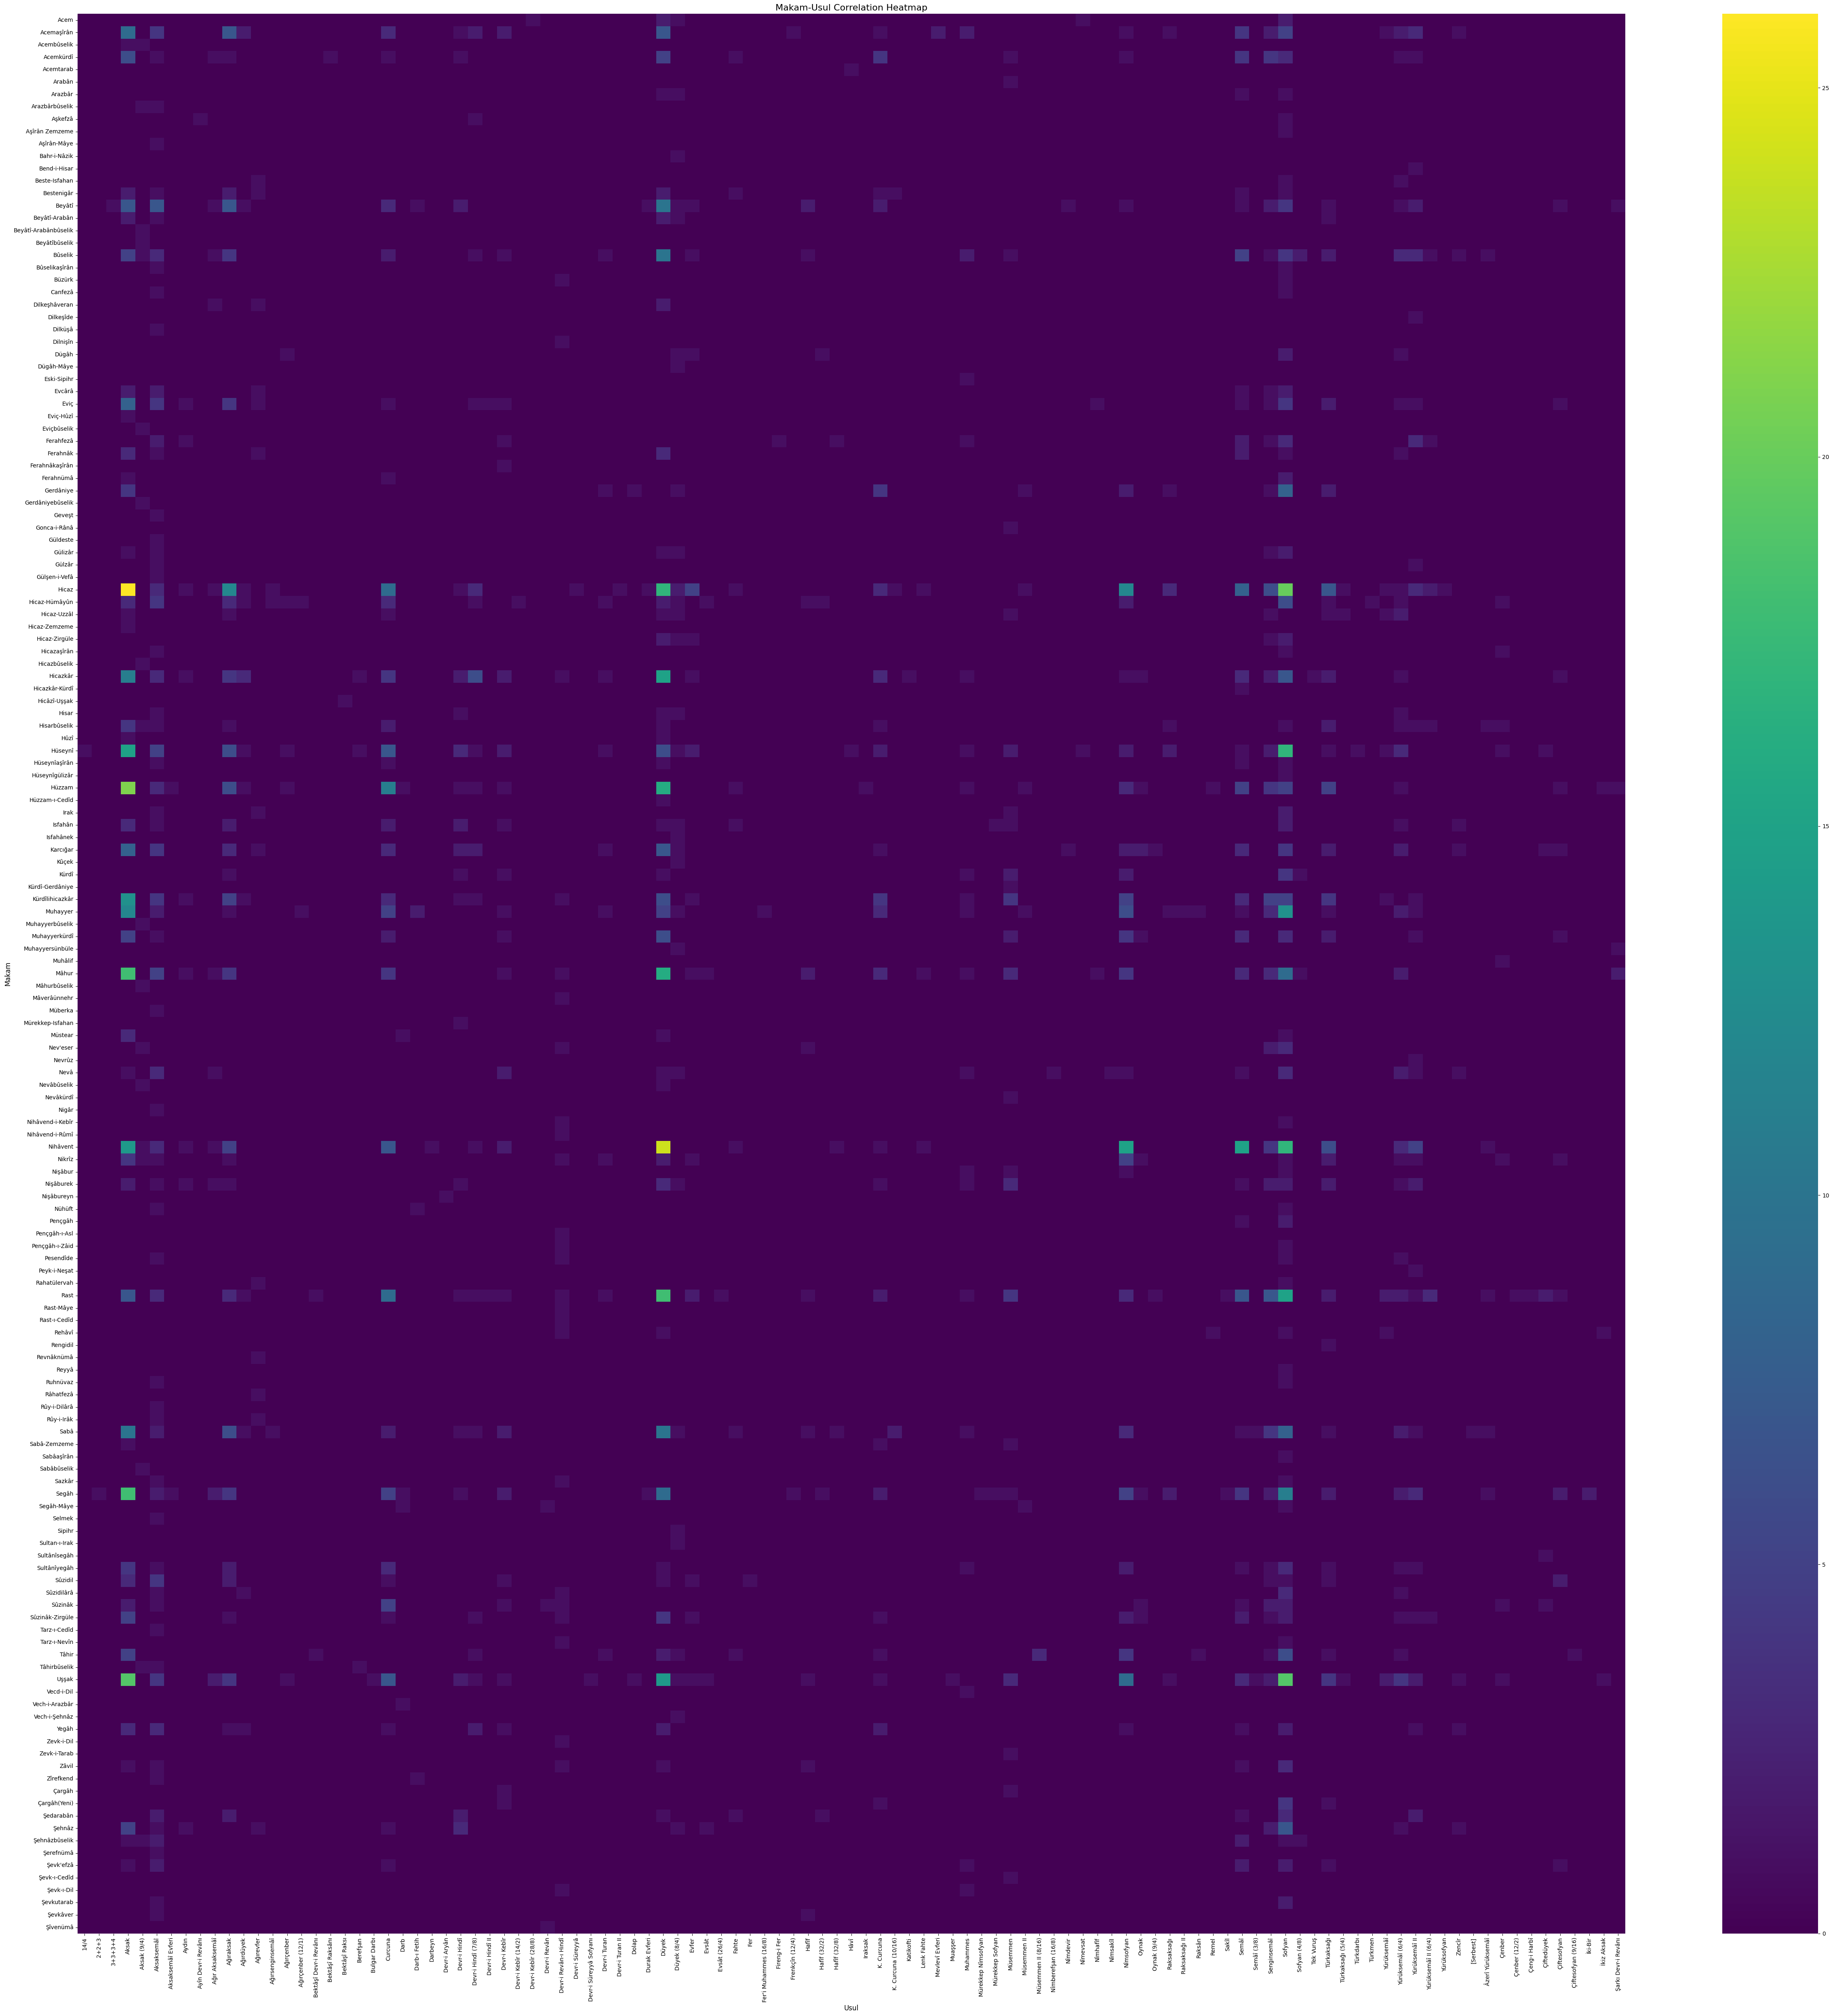

In [3]:
plt.figure(figsize=(50, 50))
sns.heatmap(df, annot=False, fmt="d", cmap="viridis")
plt.title("Makam-Usul Correlation Heatmap", fontsize=16)
plt.xlabel("Usul", fontsize=12)
plt.ylabel("Makam", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [4]:
def generate_bipartite_graph(df):
    """
    Generates a bipartite graph from the given dataframe.
    The dataframe has the Makam names as indexes and the Usul names as columns.
    Each cell contains the count of occurrences of the corresponding Makam-Usul pair.
    The function creates a bipartite graph where the first set of nodes are Makams
    and the second set are Usuls. The edges between the nodes represent the counts.
    """
    # Create a bipartite graph
    G = nx.Graph()
    # Add nodes with the bipartite attribute
    G.add_nodes_from(df.index, bipartite=0)  # Makams
    G.add_nodes_from(df.columns, bipartite=1)  # Usuls
    # Add edges with weights (counts)
    for makam in df.index:
        for usul in df.columns:
            count = df.loc[makam, usul]
            if count > 0:  # Only add edges with positive counts
                G.add_edge(makam, usul, weight=count)
    # Set the node attributes for visualization
    for makam in df.index:
        G.nodes[makam]["type"] = "makam"
    for usul in df.columns:
        G.nodes[usul]["type"] = "usul"
    # Set the weights for the edges
    for u, v, data in G.edges(data=True):
        data["weight"] = df.loc[u, v]
    # Set the graph name
    G.graph["name"] = "Makam-Usul Bipartite Graph"
    # Set the graph attributes
    G.graph["description"] = (
        "A bipartite graph representing the relationship between Makams and Usuls"
    )

    return G

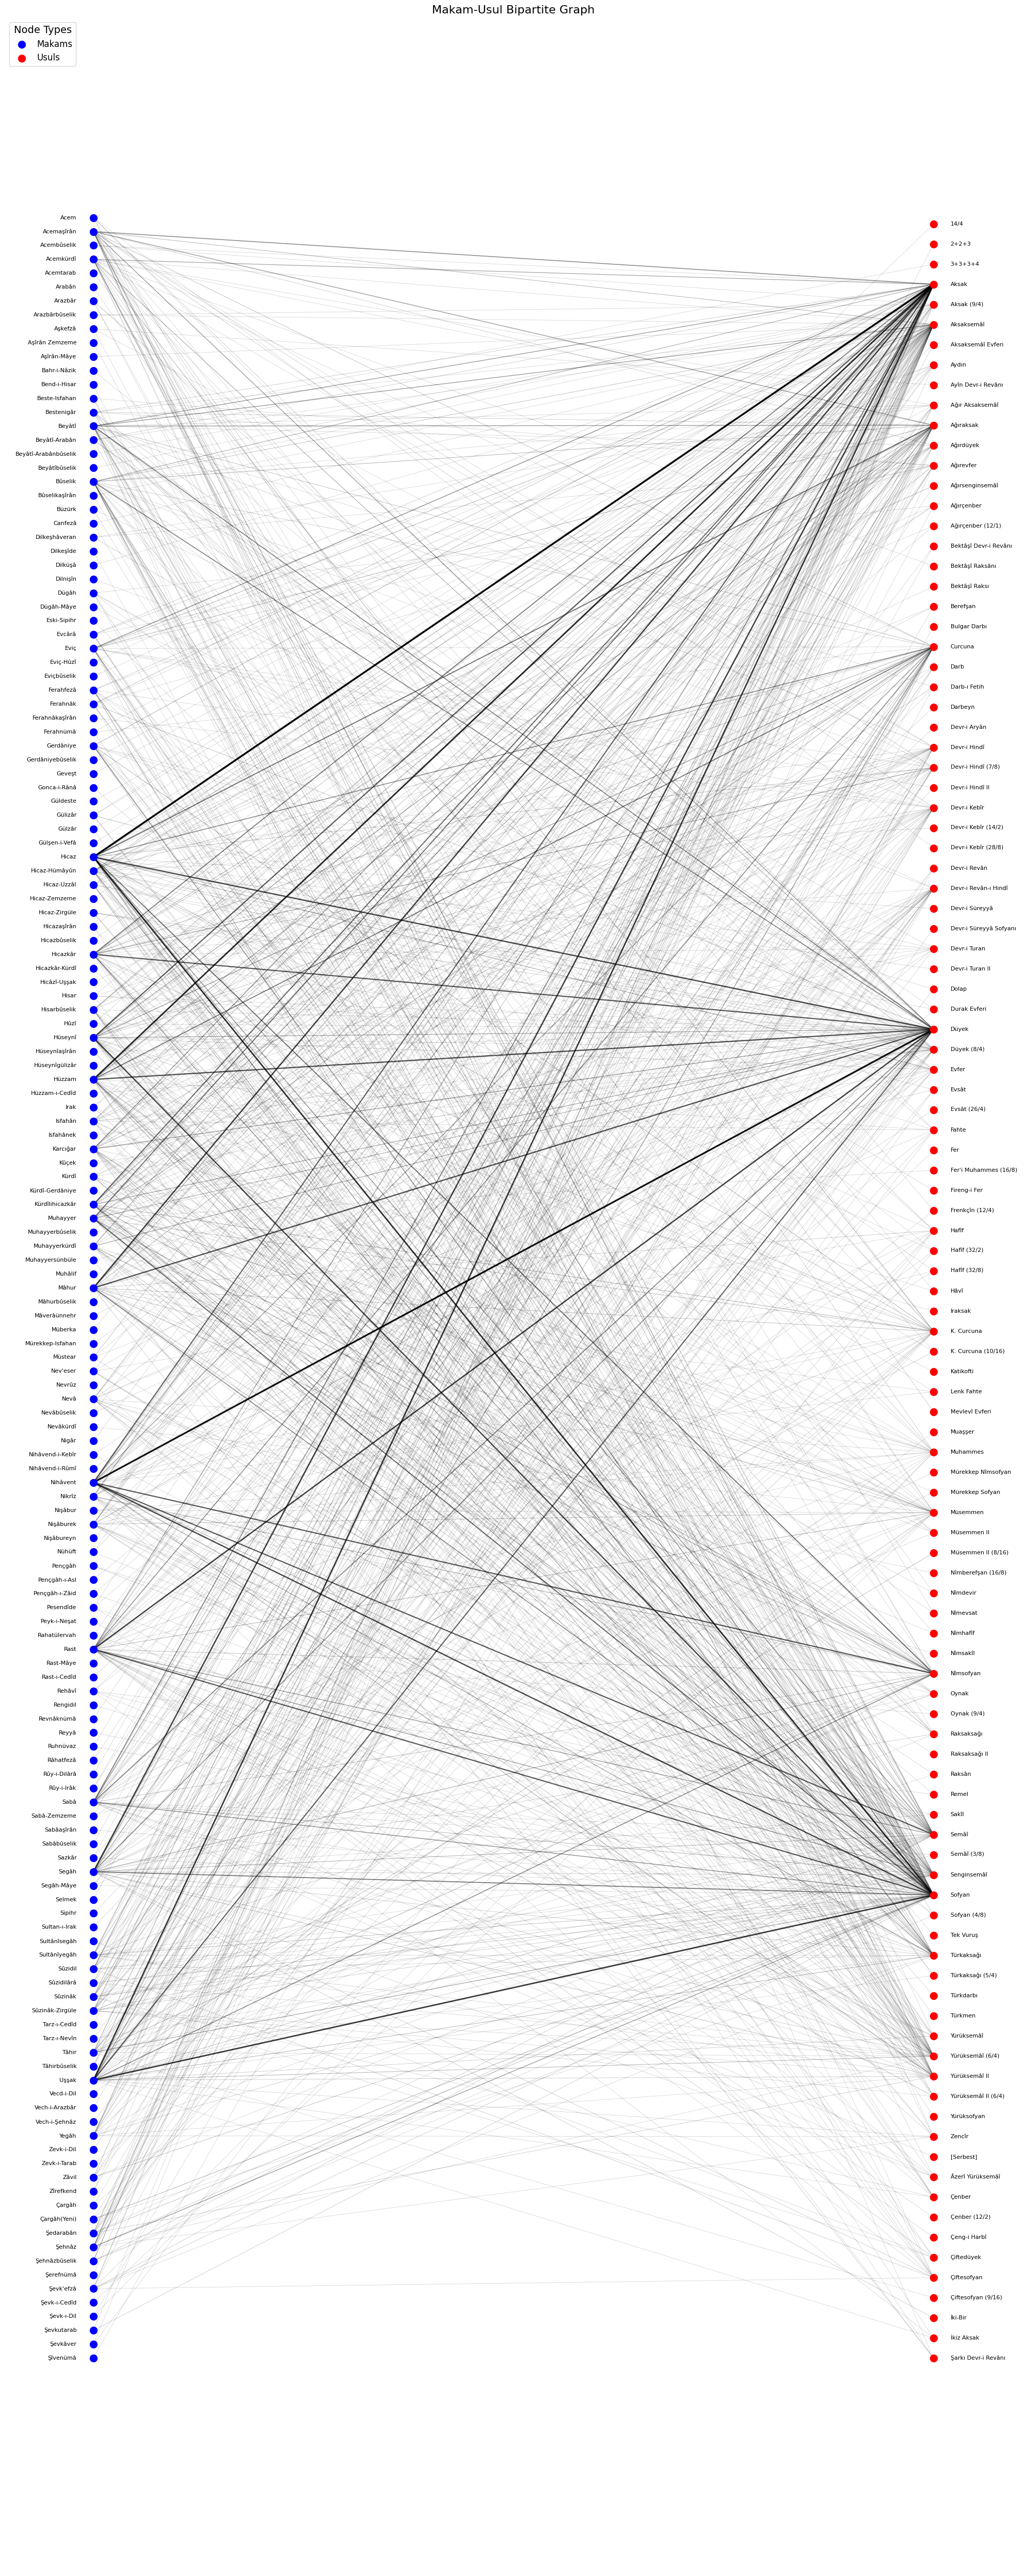

In [5]:
G = generate_bipartite_graph(df)

plt.figure(figsize=(20, 50))

left_nodes = sorted(df.index, reverse=True)  # Descending order
right_nodes = sorted(df.columns, reverse=True)  # Descending order

# Number of nodes in each set
num_left = len(left_nodes)
num_right = len(right_nodes)

# Generate positions: evenly spaced for both sets
y_left = list(range(num_left))
y_right = list(range(num_right))

# Normalize both y_left and y_right to have the same spacing
y_left = [y / num_left for y in y_left]
y_right = [y / num_right for y in y_right]

# Create manual positions for nodes
pos = {}
for i, node in enumerate(left_nodes):
    pos[node] = (0, y_left[i])  # Left column (Makams)
for i, node in enumerate(right_nodes):
    pos[node] = (1, y_right[i])  # Right column (Usuls)

# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=left_nodes,
    node_color="blue",
    node_size=100,
    label="Makams",
)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=right_nodes,
    node_color="red",
    node_size=100,
    label="Usuls",
)

# Draw edges with transparency and width based on weight
weights = [d["weight"] for u, v, d in G.edges(data=True)]
min_weight = min(weights)
max_weight = max(weights)

for u, v, d in G.edges(data=True):
    normalized_weight = (
        (d["weight"] - min_weight) / (max_weight - min_weight)
        if max_weight > min_weight
        else 0.5
    )
    width = 0.5 + 2 * normalized_weight
    alpha = 0.2 + 0.8 * normalized_weight
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=width, edge_color="black", alpha=alpha
    )

# Draw labels, offset slightly for clarity
left_pos = {node: (pos[node][0] - 0.02, pos[node][1]) for node in left_nodes}
right_pos = {node: (pos[node][0] + 0.02, pos[node][1]) for node in right_nodes}

nx.draw_networkx_labels(
    G,
    left_pos,
    labels={node: node for node in left_nodes},
    font_size=8,
    horizontalalignment="right",
)
nx.draw_networkx_labels(
    G,
    right_pos,
    labels={node: node for node in right_nodes},
    font_size=8,
    horizontalalignment="left",
)

plt.title(G.graph.get("name", "Makam-Usul Bipartite Network"), fontsize="16")
plt.axis("off")
plt.tight_layout()
plt.legend(
    loc="upper left",
    fontsize=12,
    title="Node Types",
    title_fontsize="14",
)
plt.show()

Ratio of 1+ combinations vs 0 combinations: 0.06273228245546585


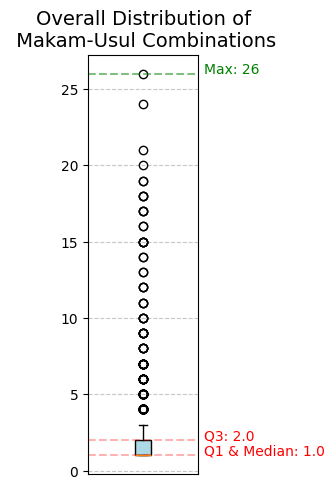

Total number of makam-usul combinations: 979
Average count per combination: 2.25
Median count per combination: 1.00
Maximum count: 26
Minimum count: 1


In [6]:
# Convert the dataframe to a single column of counts
all_counts = df.values.flatten()
print(
    f"Ratio of 1+ combinations vs 0 combinations: {len(all_counts[all_counts > 0]) / len(all_counts[all_counts == 0])}"
)
# Remove zero counts for better visualization
all_counts = all_counts[all_counts > 0]

# Create the boxplot
plt.figure(figsize=(3, 5))
plt.boxplot(
    all_counts,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
)

# Calculate percentiles
first_perc = np.percentile(all_counts, 25)
third_perc = np.percentile(all_counts, 75)
max_val = all_counts.max()

# Add dotted lines at first and third percentiles
plt.axhline(y=first_perc, color="red", linestyle="--", alpha=0.3)
plt.axhline(y=third_perc, color="red", linestyle="--", alpha=0.3)
# Add dotted line at the maximum value
plt.axhline(y=max_val, color="green", linestyle="--", alpha=0.5)

# Add text labels for the percentiles and maximum
plt.text(
    1.55,
    first_perc,
    f"Q1 & Median: {first_perc:.1f}",
    color="red",
    fontsize=10,
)
plt.text(1.55, third_perc, f"Q3: {third_perc:.1f}", color="red", fontsize=10)
plt.text(1.55, max_val, f"Max: {max_val}", color="green", fontsize=10)

plt.title("Overall Distribution of\n Makam-Usul Combinations", fontsize=14)
plt.xticks([])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Add some summary statistics
print(f"Total number of makam-usul combinations: {len(all_counts)}")
print(f"Average count per combination: {all_counts.mean():.2f}")
print(f"Median count per combination: {np.median(all_counts):.2f}")
print(f"Maximum count: {all_counts.max()}")
print(f"Minimum count: {all_counts.min()}")

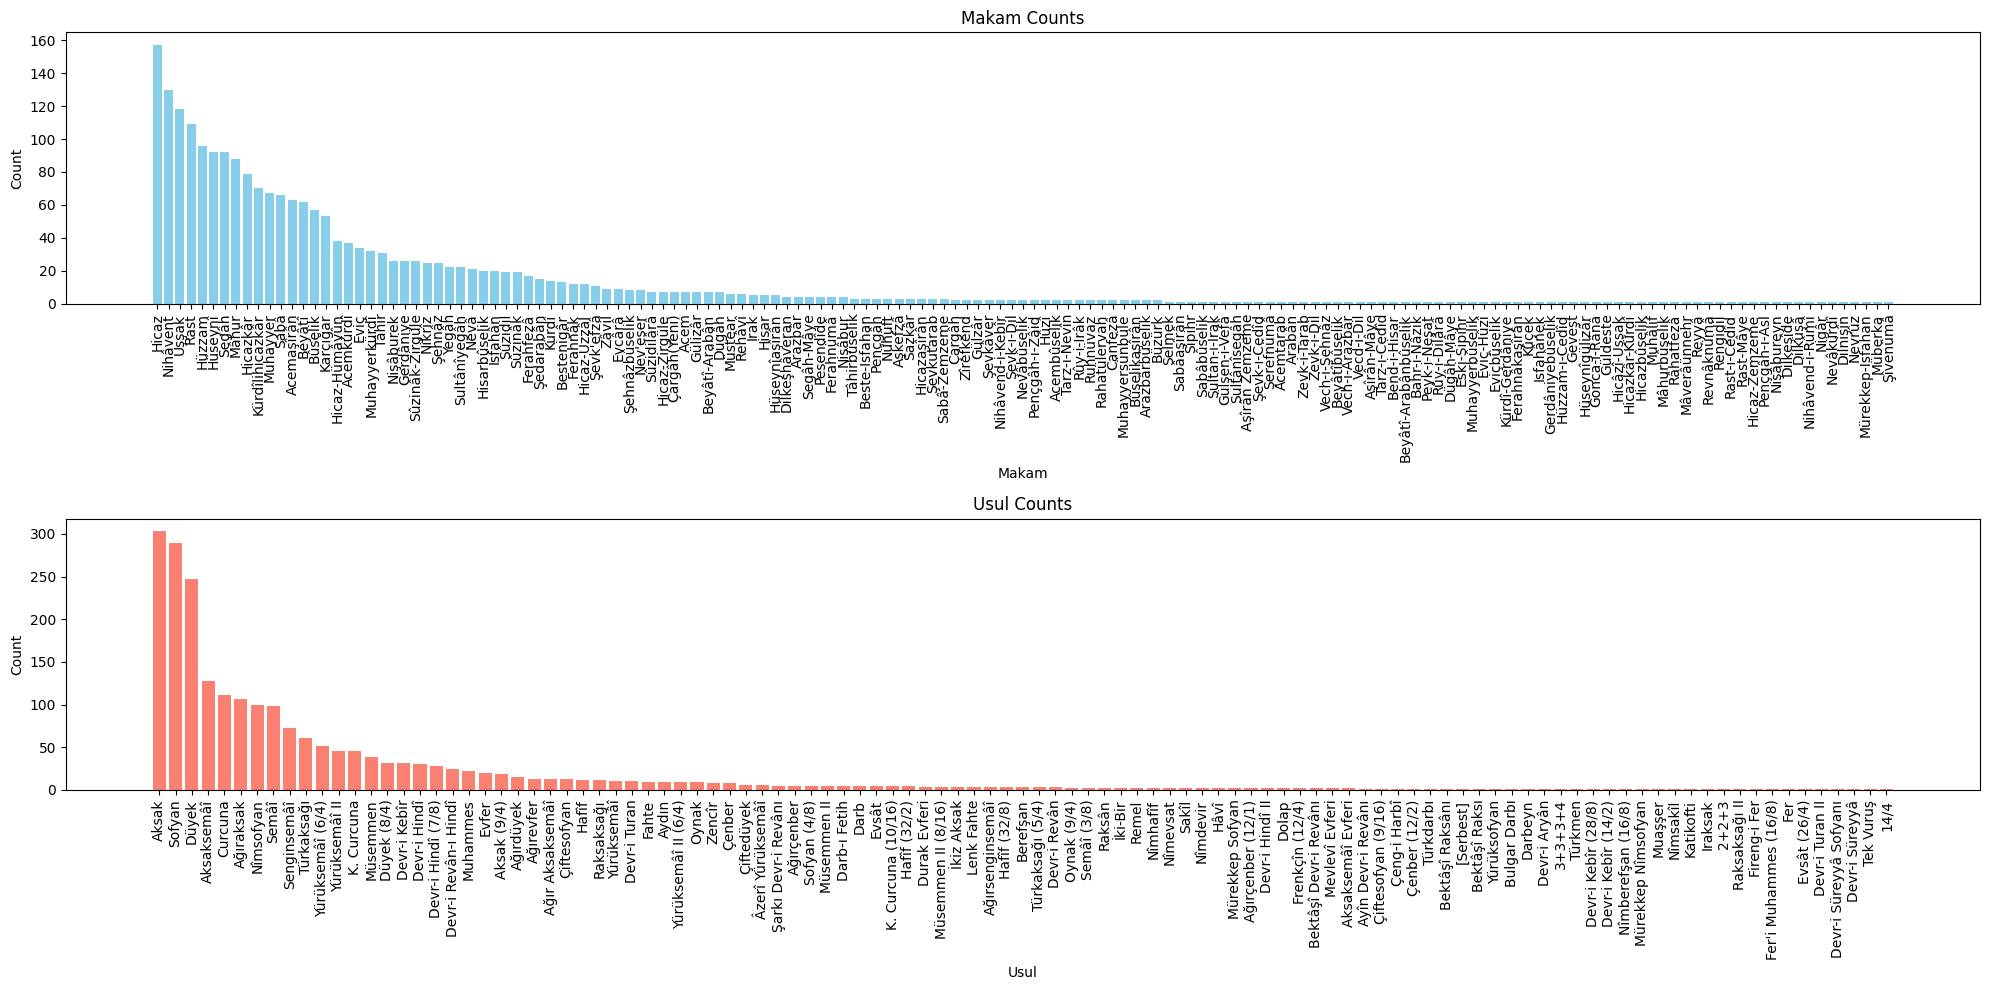

Top makams:
Hicaz              157
Nihâvent           130
Uşşak              118
Rast               109
Hüzzam              96
Hüseynî             92
Segâh               92
Mâhur               88
Hicazkâr            79
Kürdîlihicazkâr     70
dtype: int64
Top usuls:
Aksak          303
Sofyan         289
Düyek          247
Aksaksemâî     128
Curcuna        111
Ağıraksak      106
Nîmsofyan       99
Semâî           98
Senginsemâî     72
Türkaksağı      61
dtype: int64


In [7]:
makam_counts = df.sum(axis=1).sort_values(ascending=False)
usul_counts = df.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(20, 10))

# First subplot - Makam counts
plt.subplot(2, 1, 1)
plt.bar(makam_counts.index, makam_counts.values, color="skyblue")
plt.title("Makam Counts")
plt.xlabel("Makam")
plt.ylabel("Count")
plt.xticks(rotation=90)

# Second subplot - Usul counts
plt.subplot(2, 1, 2)
plt.bar(usul_counts.index, usul_counts.values, color="salmon")
plt.title("Usul Counts")
plt.xlabel("Usul")
plt.ylabel("Count")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


print("Top makams:")
print(makam_counts.head(10))
print("Top usuls:")
print(usul_counts.head(10))